In [1]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

from statsmodels.tsa.arima_model import ARIMA

import matplotlib.pyplot as plt

**Задача**

Во вложении 2 реальных временных ряда продаж продукта (деньги и упаковки). Пожалуйста, спрогнозируйте продажи на 2 года вперед оба ряда.

In [2]:
df = pd.read_excel('Real Data Analysis.xlsx', skiprows=2, header=1, usecols='B:E')
df.head()

,Year,Month,Units,RUR Gross
0,2008,янв,697817.0,6.658149e+07
1,2008,фев,852768.0,8.152511e+07
2,2008,мар,685630.0,6.685124e+07
3,2008,апр,696281.0,6.671892e+07
4,2008,май,528015.0,5.130323e+07


In [3]:
df.describe()

,Year,Units,RUR Gross
count,132.000000,132.000000,1.320000e+02
mean,2013.000000,438755.752652,6.805513e+07
std,3.174324,140189.717936,1.702396e+07
min,2008.000000,216163.000000,3.960052e+07
25%,2010.000000,336998.167500,5.463533e+07
50%,2013.000000,433164.500000,6.639066e+07
75%,2016.000000,500066.500000,7.678521e+07
max,2018.000000,909589.000000,1.367501e+08


Загрузки файла прошла успешно, также было установлено, что в исходных данных 132 строки, период данных с 2008-2018 год. Получены описательные статистики.
Далее изобразим динамику продаж в штуках и рублях.

In [4]:
sum_units = df[['Year','Units']].groupby('Year').sum().to_numpy()

In [5]:
sum_rur = df[['Year','RUR Gross']].groupby('Year').sum().to_numpy()

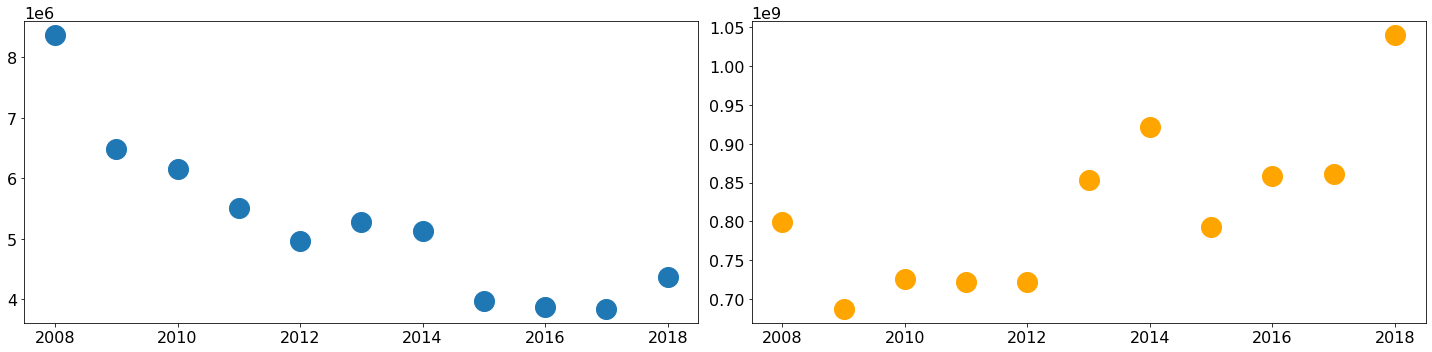

In [6]:
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["lines.markersize"] = 20
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

plt.subplot(1, 2, 1)
plt.scatter(x=df['Year'].unique(),y=sum_units)
plt.subplot(1, 2, 2)
plt.scatter(x=df['Year'].unique(),y=sum_rur, color='orange')
plt.tight_layout()
plt.show()

По графикам можно сделать следующий вывод:

1. Обе переменные имеют тренд, переменная Units имеет нисходящий тренд, а переменная RUR Gross - восходящий

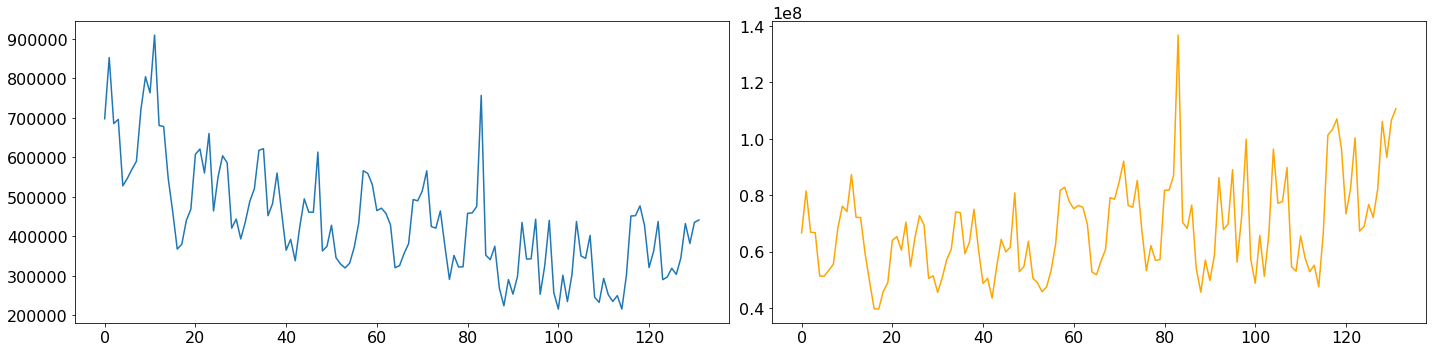

In [7]:
plt.subplot(1, 2, 1)
plt.plot(df['Units'])
plt.subplot(1, 2, 2)
plt.plot(df['RUR Gross'], color='orange')
plt.tight_layout()
plt.show()
plt.show()

Также графики демонстрируют наличие сезонности.
Тренд и сезонность необходимо убрать для обучения модели.

Проверим ряды на стационарность. Для этого воспользуемся критерием Дики-Фуллера, 

где 
1. **H0: ряд нестационарен.**
2. **H1: ряд стационарен.** 
3. **alpha = 0.05**

Критерий Дики-Фуллера: p=0.010937


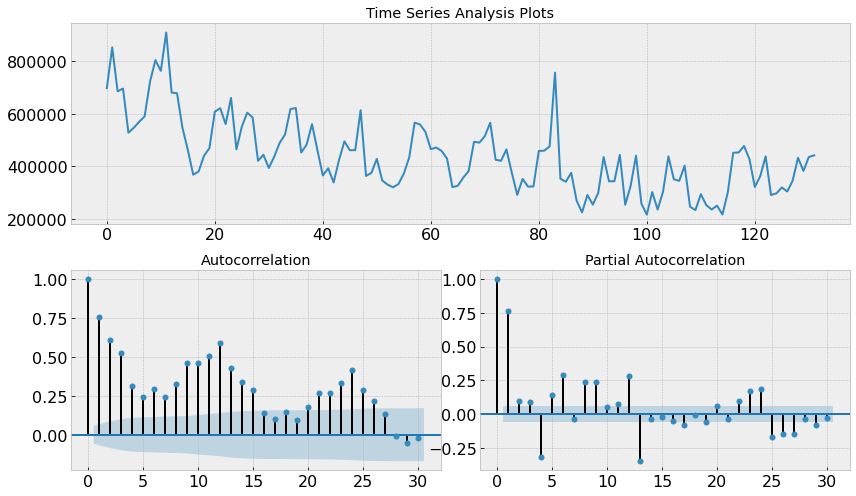

In [8]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(df['Units'], lags=30)

Для переменной Units, критерий Дики-Фуллера = 0.01, это меньше alpha, что означает, что мы не можем приянть H0, ряд стационарен.Также видим, что большинство значений находится за пределами горизонта значимости, а значит, они значимо коррелируют друг с другом. 

Критерий Дики-Фуллера: p=0.956797


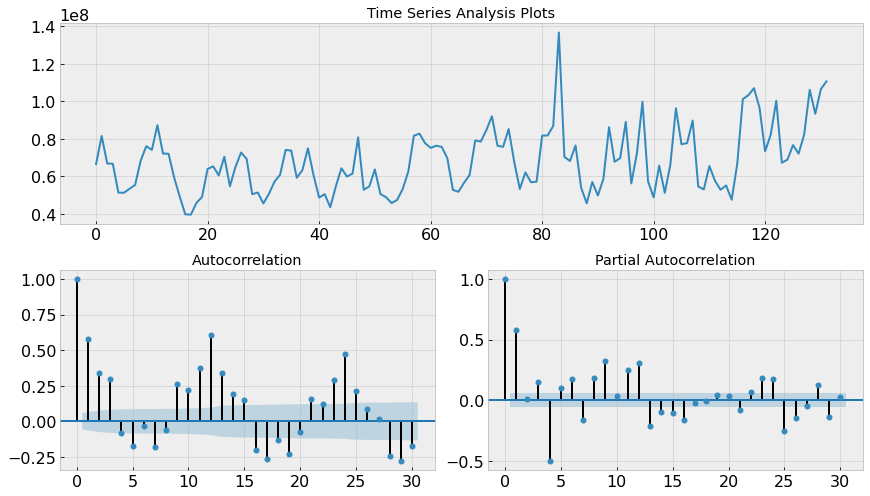

In [9]:
tsplot(df['RUR Gross'], lags=30)

Для переменной Units, критерий Дики-Фуллера = 0.95, это больше alpha, что означает, что мы не можем отвергнуть H0, ряд нестационарен.
Также видим, что большинство значений находится за пределами горизонта значимости, а значит, они значимо коррелируют друг с другом. 

Оба ряда нуждаются в дифференцировании. Можно применить boxcox трансформацию и далее подобрать кол-во итераций с дифференцированием.

Критерий Дики-Фуллера: p=0.131102


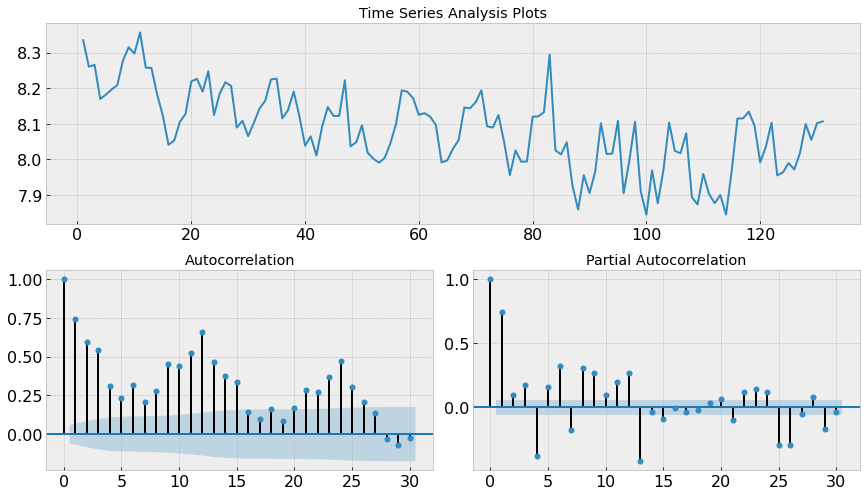

In [10]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

df['units_bc'], lambda_bc = boxcox(df['Units'])
tsplot(df['units_bc'].iloc[1:], lags=30)

После boxcox преобразования критерий Дики-Фуллера показал, что ряд стал менее стационарным, поэтому дальше его применять нет смысла. Посмотрим, как видут себя графики автокорреляции и частичной автокорреляции после 1ой итерации дифференцирования.

Критерий Дики-Фуллера: p=0.000037


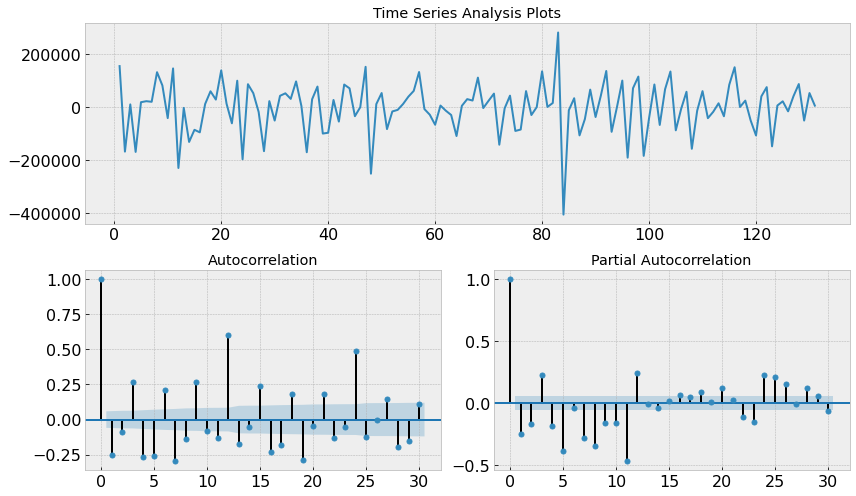

In [11]:
df['Units_diff'] = df['Units'] - df['Units'].shift(1) #попарная разность
tsplot(df['Units_diff'].iloc[1:], lags=30)

Критерий Дики-Фуллера: p=0.000002


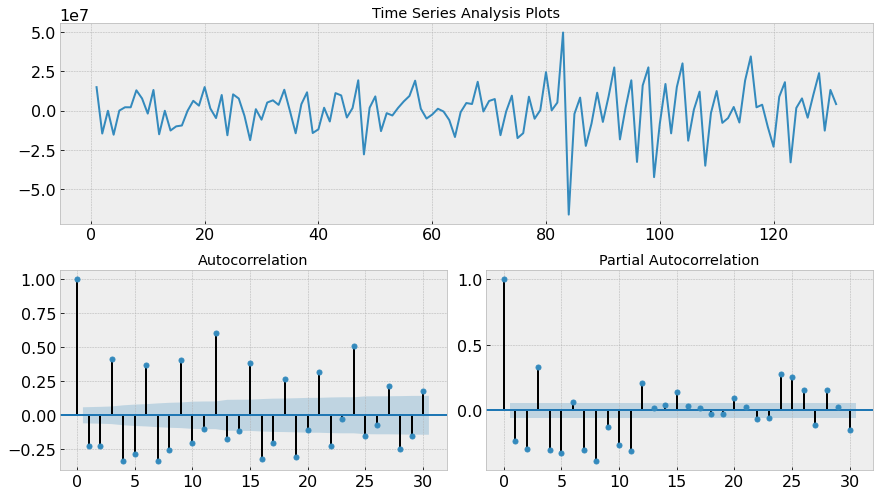

In [12]:
df['RUR_diff'] = df['RUR Gross'] - df['RUR Gross'].shift(1) #попарная разность
tsplot(df['RUR_diff'].iloc[1:], lags=30)

Для модели ARIMA попробуем подобрать параметры с учётом 2х итераций дифференцирования. Одной возможно будет не достаточно.

In [13]:
units_Xtrain = df['Units'][:108:]
units_Xtest = df['Units'][108::]

rur_Xtrain = df['RUR Gross'][:108:]
rur_Xtest = df['RUR Gross'][108::]

# UNITS

In [14]:
#ARIMA (3,2,1) Units
#order (p,d,q)
model = ARIMA(units_Xtrain, order=(3,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Units   No. Observations:                  106
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -1372.807
Method:                       css-mle   S.D. of innovations         100699.911
Date:                Mon, 27 Dec 2021   AIC                           2757.614
Time:                        13:42:12   BIC                           2773.594
Sample:                             2   HQIC                          2764.091
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            562.7552   3904.015      0.144      0.885   -7088.974    8214.484
ar.L1.D2.Units    -1.8587      0.076    -24.329      0.000      -2.008      -1.709
ar.L2.D2.Units    -1.4897      0.130

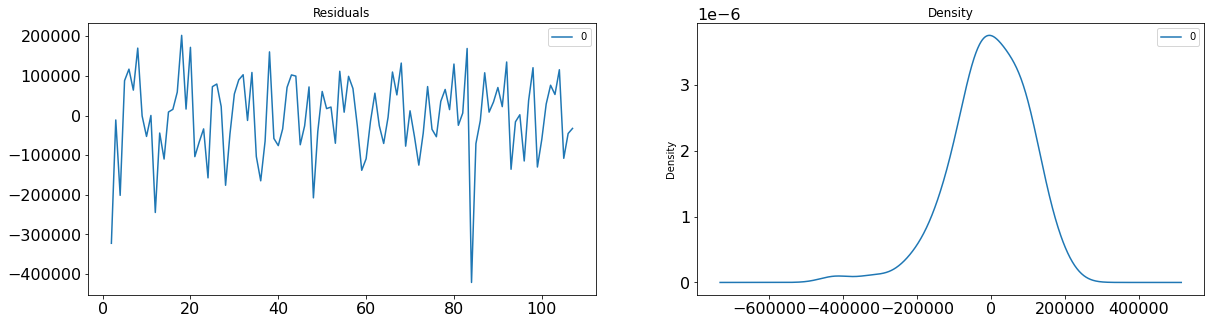

In [15]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Важно, чтобы плотность была близка к нормальному распределению, имела среднее в 0.

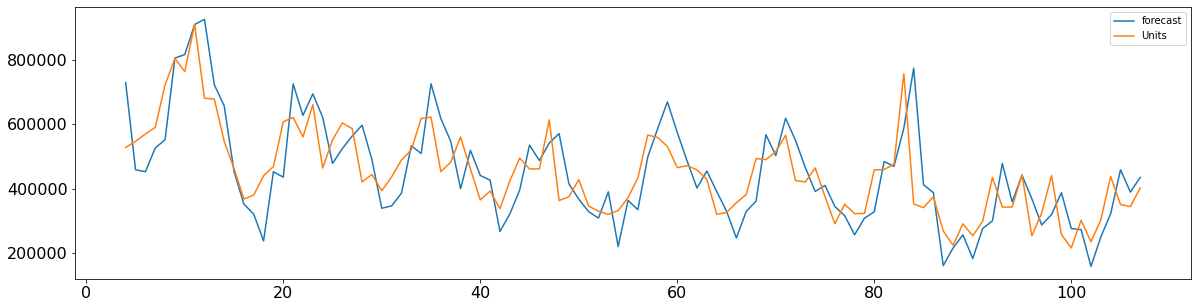

In [16]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [17]:
fc, se, conf = model_fit.forecast(24, alpha=0.05)
fc_series = pd.Series(fc, index=units_Xtest.index)
lower_series = pd.Series(conf[:, 0], index=units_Xtest.index)
upper_series = pd.Series(conf[:, 1], index=units_Xtest.index)

Метрикой качества можно выбрать MAPE (0,1) в качестве нормализированной метрики MAE (которая не чувствительная к выбросу), но можно сравнить её с MAE, MSE

In [18]:
def metrics (forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    mae = mean_absolute_error(forecast, actual)
    mse = mean_squared_error(forecast, actual)
    return({'mape':mape, 'mae':mae, 'mse': mse})

In [19]:
metrics(fc, units_Xtest)

{'mape': 0.2272046734120852, 'mae': 71107.4606140523, 'mse': 6393903841.062051}

MAPE 0.22 - наилучший результат при подборе параметров. MAE вдвое меньше среднеквадратичного отклонения, это хороший показатель.

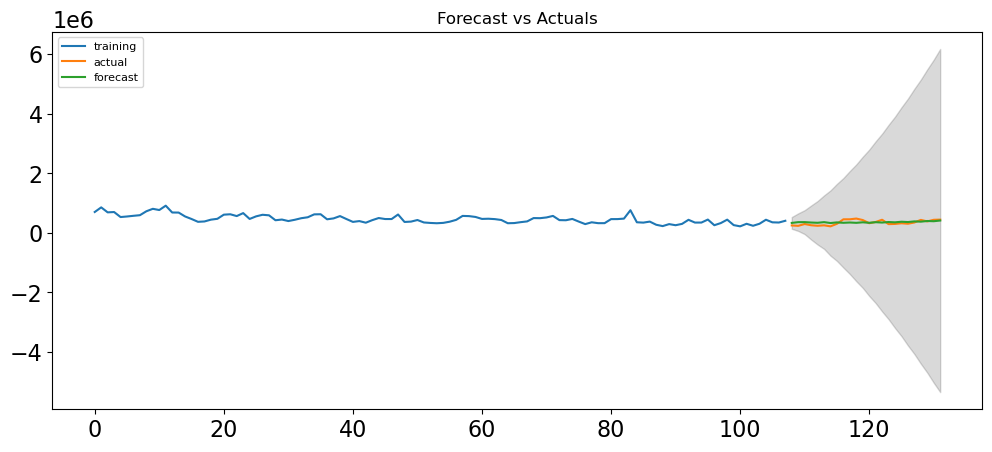

In [20]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(units_Xtrain, label='training')
plt.plot(units_Xtest, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Методом перебора параметров p q для модели было установлено, что модель с параметрами (3,2,1) даёт наименьшую ошибку.

Теперь обучим модель на всех данных и получим предсказания для будущего для переменной Units

In [21]:
model = ARIMA(df['Units'].values, order=(3,2,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  130
Model:                 ARIMA(3, 2, 1)   Log Likelihood               -1678.015
Method:                       css-mle   S.D. of innovations          96785.237
Date:                Mon, 27 Dec 2021   AIC                           3368.030
Time:                        13:44:16   BIC                           3385.235
Sample:                             2   HQIC                          3375.021
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        367.0008   3377.052      0.109      0.913   -6251.899    6985.901
ar.L1.D2.y    -1.8325      0.070    -26.082      0.000      -1.970      -1.695
ar.L2.D2.y    -1.4665      0.118    -12.457      0.0

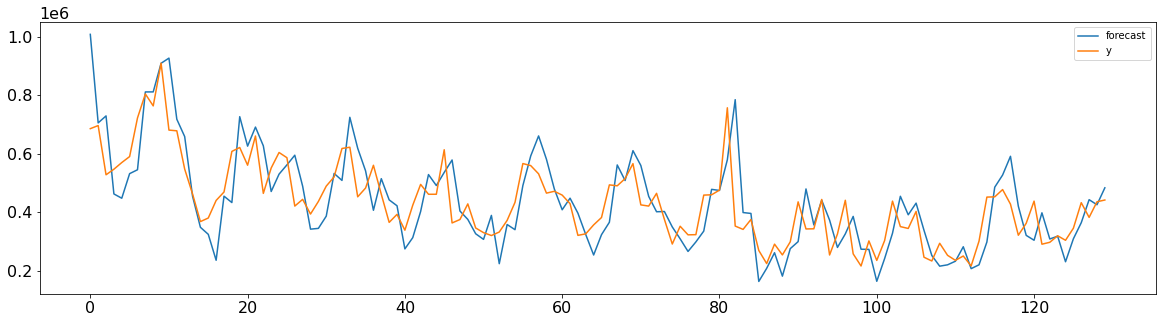

In [22]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [23]:
#делаем предсказания для признака Units на каждый месяц в следующие 2 года
units_forecast, se, conf = model_fit.forecast(24, alpha=0.05)
units_fc_series = pd.Series(units_forecast, index=np.arange(133,133+24,1))
lower_series = pd.Series(conf[:, 0], index=np.arange(133,133+24,1))
upper_series = pd.Series(conf[:, 1], index=np.arange(133,133+24,1))

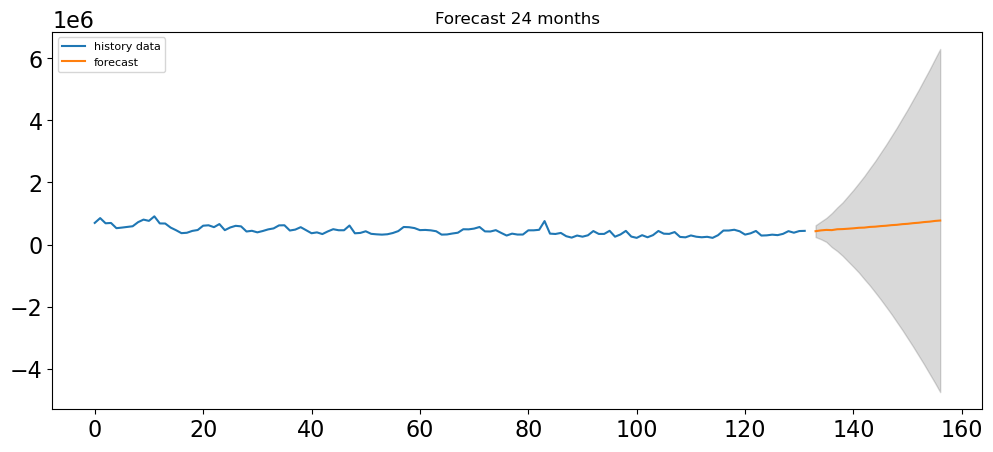

In [24]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df['Units'], label='history data')
plt.plot(units_fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast 24 months')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [25]:
units_fc_series

133    431344.751241
134    457068.072062
135    472257.694041
136    465913.193835
137    493578.067025
138    498935.569349
139    510645.781142
140    523849.769068
141    540837.424706
142    546514.358454
143    568238.025278
144    576573.209884
145    594830.976137
146    606257.533502
147    625878.658924
148    636070.056365
149    657628.100763
150    668841.241528
151    690080.279231
152    702778.536451
153    724738.499011
154    737755.412387
155    760757.291508
156    774561.305554
dtype: float64

# RUR GROSS

In [26]:
#ARIMA (3,2,1) Units
#order (p,d,q)
model = ARIMA(rur_Xtrain, order=(2,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.RUR Gross   No. Observations:                  107
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1905.399
Method:                       css-mle   S.D. of innovations       13073428.027
Date:                Mon, 27 Dec 2021   AIC                           3820.798
Time:                        13:44:27   BIC                           3834.162
Sample:                             1   HQIC                          3826.216
                                                                              
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               2.17e+05    8.5e+05      0.255      0.799   -1.45e+06    1.88e+06
ar.L1.D.RUR Gross    -0.7927      0.126     -6.299      0.000      -1.039      -0.546
ar.L2.D.RUR Gross    -0.

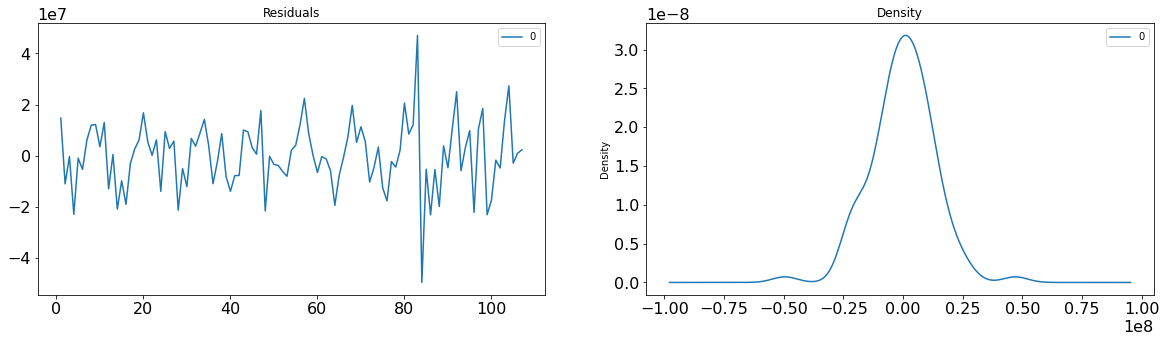

In [27]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

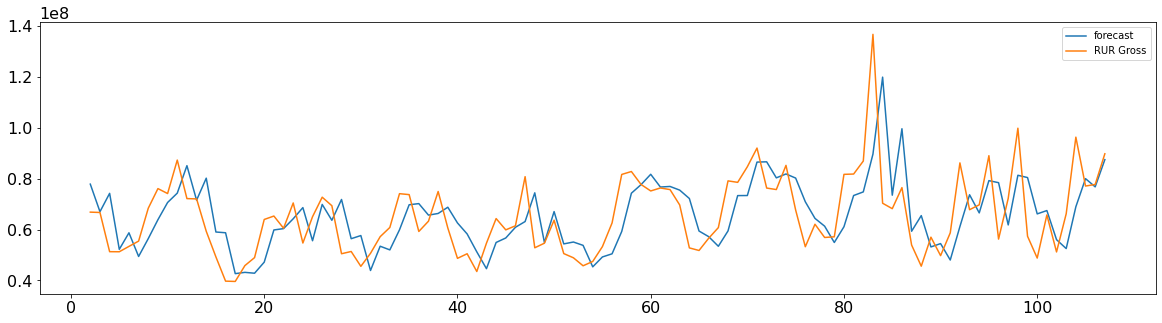

In [28]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [29]:
fc, se, conf = model_fit.forecast(24, alpha=0.05)
fc_series = pd.Series(fc, index=rur_Xtest.index)
lower_series = pd.Series(conf[:, 0], index=rur_Xtest.index)
upper_series = pd.Series(conf[:, 1], index=rur_Xtest.index)

In [30]:
metrics(fc, rur_Xtest)
#ошибки высокие, даже с учётом того, что mae близко к среднеквадратичному отклонению, но это наилучшая комбинация

{'mape': 0.27503610431018666,
 'mae': 18735168.20202416,
 'mse': 421176919152790.7}

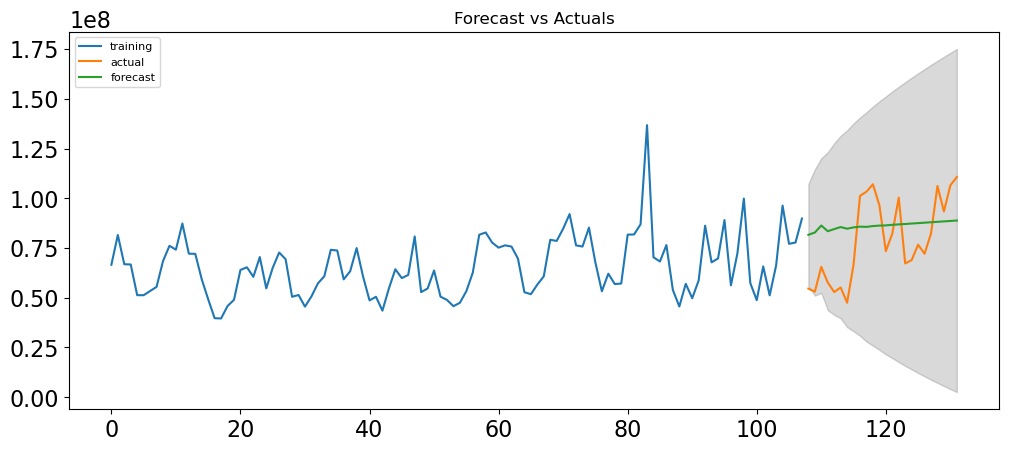

In [31]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(rur_Xtrain, label='training')
plt.plot(rur_Xtest, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Стоит отметить, что подбор параметров осуществлялся вручную

Обучим на всей выборке, чтобы сделать предсказания. Модель с параметрами 1,1,1 показала наивысшей MAPE, однако не может быть дифференцирована на всей выборке, так как обратной матрицы не существует.

In [32]:
model = ARIMA(df['RUR Gross'].values, order=(2,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  131
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2336.594
Method:                       css-mle   S.D. of innovations       13467037.107
Date:                Mon, 27 Dec 2021   AIC                           4683.188
Time:                        13:44:46   BIC                           4697.564
Sample:                             1   HQIC                          4689.029
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.365e+05   8.18e+05      0.411      0.681   -1.27e+06    1.94e+06
ar.L1.D.y     -0.7567      0.113     -6.714      0.000      -0.978      -0.536
ar.L2.D.y     -0.4628      0.078     -5.948      0.0

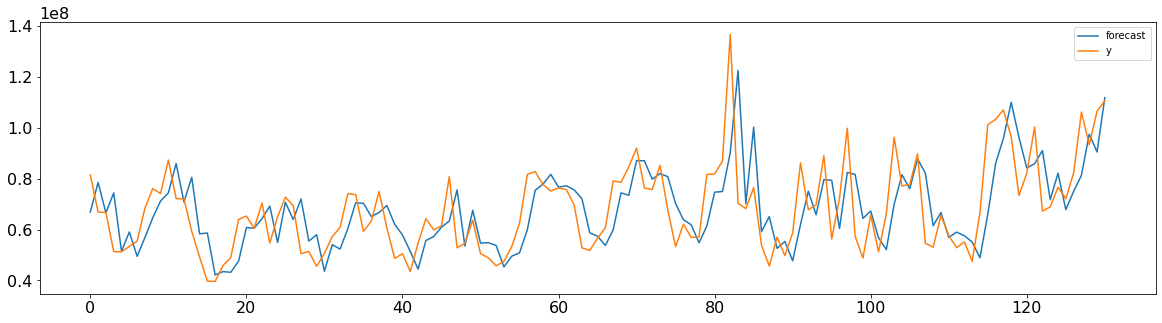

In [33]:
model_fit.plot_predict(dynamic=False)
plt.show()

In [34]:
#делаем предсказания для признака RUR Gross на каждый месяц в следующие 2 года
rur_forecast, se, conf = model_fit.forecast(24, alpha=0.05)
rur_fc_series = pd.Series(rur_forecast, index=np.arange(133,133+24,1))
lower_series = pd.Series(conf[:, 0], index=np.arange(133,133+24,1))
upper_series = pd.Series(conf[:, 1], index=np.arange(133,133+24,1))

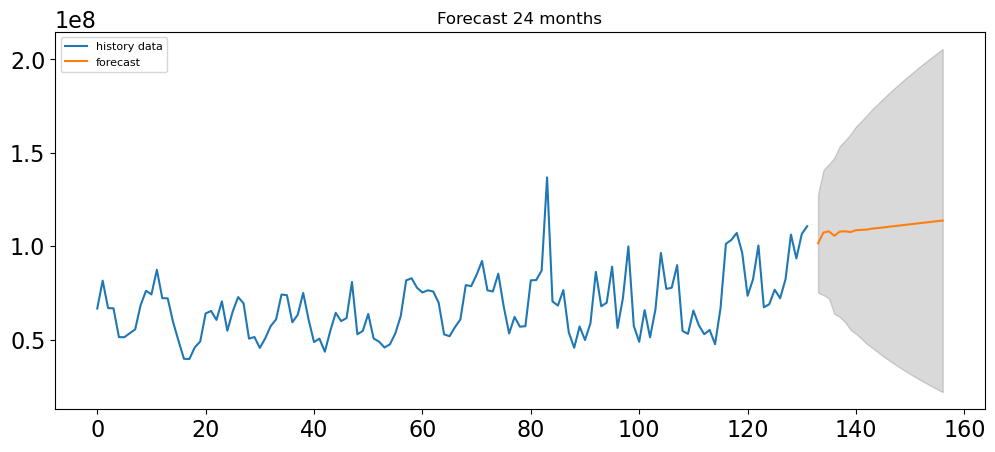

In [35]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df['RUR Gross'], label='history data')
plt.plot(rur_fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast 24 months')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [36]:
rur_fc_series

133    1.015373e+08
134    1.072760e+08
135    1.079035e+08
136    1.055196e+08
137    1.077799e+08
138    1.079197e+08
139    1.075147e+08
140    1.085033e+08
141    1.086895e+08
142    1.088379e+08
143    1.093863e+08
144    1.096495e+08
145    1.099434e+08
146    1.103460e+08
147    1.106522e+08
148    1.109810e+08
149    1.113373e+08
150    1.116624e+08
151    1.119983e+08
152    1.123405e+08
153    1.126729e+08
154    1.130099e+08
155    1.133479e+08
156    1.136830e+08
dtype: float64

Для улучшения качества модели можно попробовать не линейные модели. Либо добавить константу к имеющимся. Для этого нужен более глубокий анализ.